In [56]:
import numpy as np
import json
import cv2
import pickle

from PIL import Image
from Haar import harr
from svm import SVM
from SelectiveSearch import get_windows
from matplotlib import pyplot as plt
from tools.get_rec_dataset import get_dataset
from eigenface import Eigenface
from tools.iou import cal_iou
%matplotlib inline

100%|██████████| 76/76 [00:07<00:00, 10.31it/s]


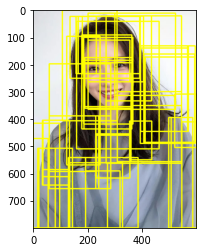

In [57]:
# 读取训练完成的svm模型
svm = SVM()
with open("models/svm_params.pkl", 'rb') as file:
    svm = pickle.loads(file.read())

# 选取图片路径
img_path = 'dataset/shiyuanlimei/shiyuanlimei_14.png'

# 读取图片
img = cv2.imread(img_path)

# 转为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 从图片中提取一系列子窗口
effectiveWindows = get_windows(img)

# 对每个子窗口提取X2 Haar特征
haar_features = []
for bbox in effectiveWindows:
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    cropImg = img_gray[y:y+h, x:x+w]
    cropImg = cv2.resize(cropImg, (20, 20))
    feature = harr(cropImg)
    haar_features.append(feature)
haar_features = np.array(haar_features)

# 获取所有子窗口的预测类别
result = svm.predict(haar_features)

# 获取预测含有人脸的区域
p_bboxs = []
for i in range(len(effectiveWindows)):
    if result[i] == 1:
        p_bboxs.append(effectiveWindows[i])

for bbox in p_bboxs:
    cv2.rectangle(img, (bbox[0], bbox[1]),
                  (bbox[0] + bbox[2], bbox[1] + bbox[3]),
                  (0, 255, 255), 3)

# 输出所有子窗口中预测为人脸区域的
p_windows = img[:,:,::-1] # 将opencv图片格式转为plt
plt.imshow(p_windows)
plt.show()

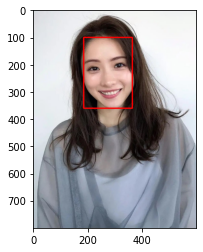

In [58]:
# 重新读取图片
img = cv2.imread(img_path)

# 选择与其他窗口iou总和最高的窗口作为检测结果

sum_iou = []
for i in range(len(p_bboxs)):
    tmp_bbox = p_bboxs[i]
    tmp_sum = 0
    for bbox in p_bboxs:
        tmp_sum += cal_iou(tmp_bbox, bbox)
    sum_iou.append(tmp_sum)

max_index = sum_iou.index(max(sum_iou))

result_bbox = p_bboxs[max_index]

cv2.rectangle(img, (result_bbox[0], result_bbox[1]),
                  (result_bbox[0] + result_bbox[2], result_bbox[1] + result_bbox[3]),
                  (0, 0, 255), 3)

# 输出检测最终结果
predict = img[:,:,::-1] # 将opencv图片格式转为plt
plt.imshow(predict)
plt.show()

In [59]:
# 读取所有原始图片路径和对应的label
with open ('jsons/dataset.json', 'r') as f:
    dataset = json.load(f)

# 人脸类别及其对应编号
CLASSES = {
    'curry':0,
    'dujiang':1,
    'huangbo':2,
    'JacksonYee':3,
    'jingtian':4,
    'JohnMayer':5,
    'kobe':6,
    'shiyuanlimei':7,
    'xuezhiqian':8,
    'dili':9
}

'''
    截取所有的人脸区域并缩放至(100, 100)并flatten至10000维的一维向量，每一类随机选5张人脸作为训练集，共10类，剩余作为测试集
    train_imgs: 存放训练集的所有人脸图片，shape = (50, 10000)
    class_train_imgs: 该列表存放10个array(array.shape = (5, 10000))，分别为10类人脸图片, len(class_train_imgs) = 10
    train_cls: 该列表存放上述10个array所对应的人脸类别, len(train_cls) = 10
    test_imgs: 存放测试集的所有人脸图片, shape = (168, 10000)
    test_cls: 该列表存放测试集每张人脸图片的类别，len(test_cls) = 168
'''
train_imgs, class_train_imgs, train_cls, test_imgs, test_cls = get_dataset(dataset)

eigenface = Eigenface()

# 对训练集进行样本主成分分析
eigenface.pca(train_imgs, class_train_imgs)

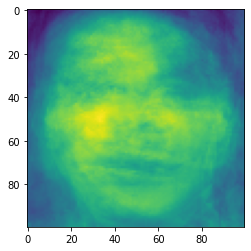

In [60]:
# 获取平均脸
mean_face = eigenface.mean_image.reshape(100, 100)
plt.imshow(mean_face)
plt.show()

In [ ]:
# 将检测结果剪切下来，并缩放到(100, 100)
x, y, w, h = result_bbox[0], result_bbox[1], result_bbox[2], result_bbox[3]
cropImg = img[y:y + h, x:x + w]
cropImg = cv2.resize(cropImg, (100, 100))
cropImg = Image.fromarray(cv2.cvtColor(cropImg, cv2.COLOR_BGR2GRAY))
cropImg = np.array(cropImg, dtype=np.uint8).flatten()

# 使用KNN对测试图片进行类别预测
predict_cls = eigenface.KNN_predicgt(test_imgs[0], train_cls)

name = [k for k,v in CLASSES.items() if v==predict_cls]

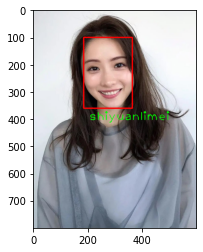

In [55]:
# 重新读取图片
img = cv2.imread(img_path)

# 画框
cv2.rectangle(img, (result_bbox[0], result_bbox[1]),
                  (result_bbox[0] + result_bbox[2], result_bbox[1] + result_bbox[3]),
                  (0, 0, 255), 3)


# 将识别结果输出于图像
cv2.putText(img, name[0], (x + 20, y + h + 45), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 2)

predict = img[:,:,::-1] # 将opencv图片格式转为plt
plt.imshow(predict)
plt.show()